# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


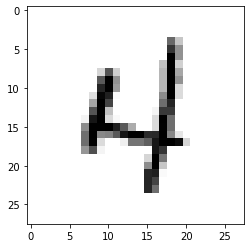

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

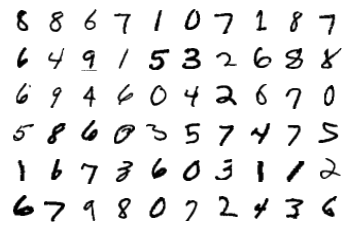

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 20, 22, 22]           1,800
              ReLU-6           [-1, 20, 22, 22]               0
         MaxPool2d-7           [-1, 20, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             200
              ReLU-9           [-1, 10, 11, 11]               0
           Conv2d-10             [-1, 10, 9, 9]             900
             ReLU-11             [-1, 10, 9, 9]               0
           Conv2d-12             [-1, 20, 7, 7]           1,800
             ReLU-13             [-1, 20, 7, 7]               0
           Conv2d-14             [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.5768435001373291 Batch_id=468 Accuracy=49.34: 100%|██████████| 469/469 [00:20<00:00, 23.44it/s]



Test set: Average loss: 0.3008, Accuracy: 9036/10000 (90.36%)

EPOCH: 1


Loss=0.14644919335842133 Batch_id=468 Accuracy=94.04: 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]



Test set: Average loss: 0.1046, Accuracy: 9699/10000 (96.99%)

EPOCH: 2


Loss=0.14217111468315125 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:19<00:00, 23.66it/s]



Test set: Average loss: 0.0667, Accuracy: 9796/10000 (97.96%)

EPOCH: 3


Loss=0.02563459984958172 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s]



Test set: Average loss: 0.0654, Accuracy: 9804/10000 (98.04%)

EPOCH: 4


Loss=0.02708909846842289 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]



Test set: Average loss: 0.0588, Accuracy: 9809/10000 (98.09%)

EPOCH: 5


Loss=0.0448233000934124 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:20<00:00, 23.41it/s]



Test set: Average loss: 0.0486, Accuracy: 9846/10000 (98.46%)

EPOCH: 6


Loss=0.018820857629179955 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:20<00:00, 23.31it/s]



Test set: Average loss: 0.0594, Accuracy: 9819/10000 (98.19%)

EPOCH: 7


Loss=0.07971525937318802 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s]



Test set: Average loss: 0.0520, Accuracy: 9828/10000 (98.28%)

EPOCH: 8


Loss=0.01586323417723179 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s]



Test set: Average loss: 0.0497, Accuracy: 9836/10000 (98.36%)

EPOCH: 9


Loss=0.006822418887168169 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:19<00:00, 23.54it/s]



Test set: Average loss: 0.0515, Accuracy: 9839/10000 (98.39%)

EPOCH: 10


Loss=0.07575983554124832 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]



Test set: Average loss: 0.0428, Accuracy: 9875/10000 (98.75%)

EPOCH: 11


Loss=0.11376380175352097 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]



Test set: Average loss: 0.0398, Accuracy: 9873/10000 (98.73%)

EPOCH: 12


Loss=0.017818739637732506 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:20<00:00, 22.82it/s]



Test set: Average loss: 0.0462, Accuracy: 9857/10000 (98.57%)

EPOCH: 13


Loss=0.05362428352236748 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:20<00:00, 23.12it/s]



Test set: Average loss: 0.0362, Accuracy: 9881/10000 (98.81%)

EPOCH: 14


Loss=0.009242483414709568 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]



Test set: Average loss: 0.0381, Accuracy: 9876/10000 (98.76%)

EPOCH: 15


Loss=0.023598289117217064 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]



Test set: Average loss: 0.0380, Accuracy: 9884/10000 (98.84%)

EPOCH: 16


Loss=0.017221881076693535 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:20<00:00, 23.38it/s]



Test set: Average loss: 0.0414, Accuracy: 9873/10000 (98.73%)

EPOCH: 17


Loss=0.01727808453142643 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]



Test set: Average loss: 0.0412, Accuracy: 9868/10000 (98.68%)

EPOCH: 18


Loss=0.005863344296813011 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]



Test set: Average loss: 0.0419, Accuracy: 9868/10000 (98.68%)

EPOCH: 19


Loss=0.007753197103738785 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:20<00:00, 23.03it/s]



Test set: Average loss: 0.0333, Accuracy: 9895/10000 (98.95%)



Text(0.5, 1.0, 'Test Accuracy')

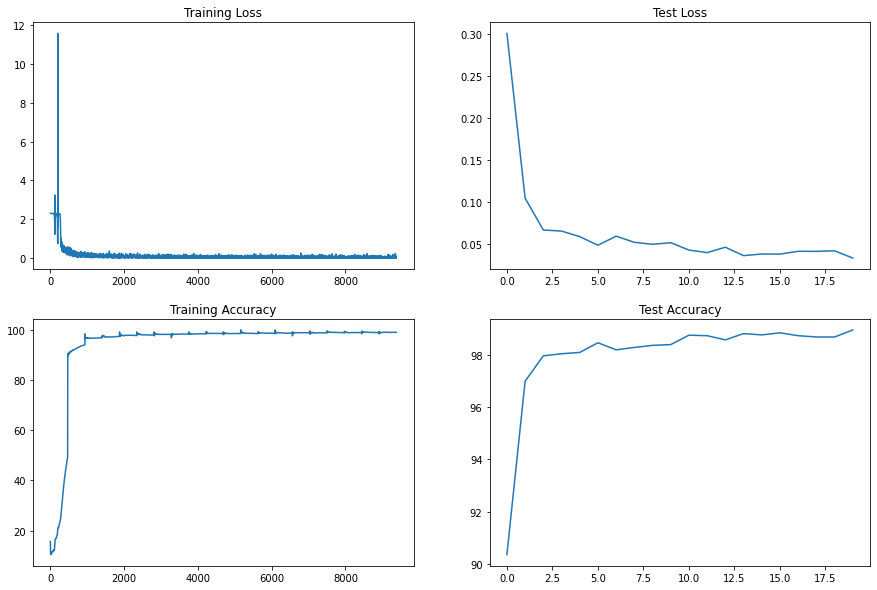

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Made a slight change to the previous model, changing the output channels to only 10 or 20 and not applying padding.                    
This lead to less parameters then previous code. but again it lead to underfitting of the model. and we dont want that.
At some Epoch it gave like a good model but we look at overall.